**Introduction**

In this prototype model I am looking to create a basic classification model based on a dataset containing 1600 reviews, half being a mixture of truthful and the other half being deceptive. The deceptive reviews are from amazons mechanical turk program, where participants are told to create a review based on an experience they had never had. My aim is that by creating an initial model based on human deception, I will be able to later adapt the model with further training and tweaking into finding the different type of langauge used by a machines produced fake review.

The dataset being used was created by a mixture of data from two studies into computational linguistics; M. Ott, Y. Choi, C. Cardie, and J.T. Hancock. [2011] and M. Ott, C. Cardie, and J.T. Hancock. [2013]. Data that is truthful are real reviews for hotels in Chicago taken from the sites Expedia, Hotels.com, Orbitz, Priceline, TripAdvisor and Yelp.


In [1]:
import os
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ["TFHUB_CACHE_DIR"] = '/tmp/tfhub'

url = 'https://raw.githubusercontent.com/thestianchris/FakeReviewDetect/main/deceptive-opinion.csv'
df = pd.read_csv(url)
print(df.shape)
df.sample()

(1600, 5)


,deceptive,hotel,polarity,source,text
1020,truthful,talbott,negative,Web,I selected the Talbott after 3 hrs comparing h...


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2256667758651389973
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5423554560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13708207820842601558
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:08:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


**Methodology**

Commonsense baseline for indication of a deceptive or truthful review comes at a level of 50% accuracy if taken at a random guess

standardize the data, token and indexing

Standardise the text data in order to get rid of any encoding issues that might give different weight to text data based on capitalization and punctuation differences.

tokenize using word2vec

using lstm model

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#Standardise
for columns in df.columns:
    df['text'] = df['text'].str.lower()   #Covert the text to lower case
    df['text'].str.replace('[^\w\s]','') #Remove punctuation
    df['text'].str.strip() #Remove whitespace
    df['text'].str.replace("\n", " ") #Remove escape characters

#Shuffle the dataset to stop the model from picking up pattern of deceptive then truthful
df = shuffle(df)

#Get the max token from training data to be used in model
max_length = 0
for row in df['text']:
    if len(row.split(" ")) > max_length:
        max_length = len(row.split(" "))

print(max_length)

text_data = df['text'].values  #Get the data from the dataset to be used in model, we only are focused on the review and deceptive label
labels = df['deceptive'].values

#Split the data into test and train data with a 80/20 split, with 80% going to the train data
test_data, train_data, test_label, train_label = train_test_split(text_data,labels, test_size = 0.8, random_state = 0)

print(len(test_data))

784
320


C:\Users\Christian Gauthier\AppData\Local\Temp\ipykernel_28612\2821475478.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'].str.replace('[^\w\s]','') #Remove punctuation


In [5]:
# Load Pretrained Word2Vec
import tensorflow_hub as hub
embed = hub.load('Embed')
embeddings = embed(["A long sentence.", "single-word", "http://example.com"])
print(embeddings.shape, embeddings.dtype)


(3, 500) <dtype: 'float32'>


In [4]:
def get_word2vec_enc(reviews):
    encoded_reviews = []
    for review in reviews:
        tokens = review.split(" ")
        word2vec_embedding = embed(tokens)
        encoded_reviews.append(word2vec_embedding)
    return encoded_reviews

def get_padded_encoded_reviews(encoded_reviews):
    #Pad all the reviews so that they have the same length for model 
    padded_reviews_encoding = []
    for enc_review in encoded_reviews:
        zero_padding_cnt = max_length - enc_review.shape[0]
        pad = np.zeros((1, 500)) #Value of 500 used as we are making a vector size of 500 word relation
        for i in range(zero_padding_cnt):
            enc_review = np.concatenate((pad, enc_review), axis=0)
        padded_reviews_encoding.append(enc_review)
    return padded_reviews_encoding

def label_encode(label):
    #encode label (One Hot)
    if label == 'truthful':
        return [1,0]
    else:
        return [0,1]

In [7]:
#Encode the reviews
'''
padded_encoded__train_reviews = get_padded_encoded_reviews(get_word2vec_enc(train_data))
padded_encoded__test_reviews = get_padded_encoded_reviews(get_word2vec_enc(test_data))
#Encode the labels
encoded_train_label = [label_encode(label) for label in train_label]
encoded_test_label = [label_encode(label) for label in test_label]
'''


In [5]:
#Turn values into numpy arrays so can be used in model
'''
train_data = np.array(padded_encoded__train_reviews)
train_label = np.array(encoded_train_label)

test_data = np.array(padded_encoded__test_reviews)
test_label = np.array(encoded_test_label)

#Save locally
np.save('train_data', train_data)
np.save('train_label', train_label)
np.save('test_data', test_data)
np.save('test_label', test_label)

'''
#Load locally
train_data = np.load('train_data.npy')
train_label= np.load('train_label.npy')

test_data = np.load('test_data.npy')
test_label = np.load('test_label.npy')

print(len(test_data))
print(len(test_label))

print(train_data.shape)
print(test_label.shape)

320
320
(1280, 784, 500)
(320, 2)


In [8]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# LSTM model 
'''
model = Sequential()
model.build(input_shape=(train_data.shape))   
model.add(layers.LSTM(100))                
model.add(tf.keras.layers.Dropout(0.5))   
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),
                                bias_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.5))      
model.add(tf.keras.layers.Dense(16, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))          
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
'''
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100),

    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(32, activation='relu',
                                kernel_regularizer=regularizers.l2(0.001),
                                bias_regularizer=regularizers.l2(0.001)),
    
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(16, activation='relu',
                                kernel_regularizer=regularizers.l2(0.001),
                                bias_regularizer=regularizers.l2(0.001)),

    # Add a dense output layer with 2 units and sigmoid activation as output
    tf.keras.layers.Dense(2, activation='sigmoid')

])


# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    train_data, 
    train_label, 
    epochs = 250,
    batch_size = 100
) 

model.save('saved_model/my_model')
model.summary()   


Epoch 1/250
13/13 [==============================] - 31s 226ms/step - loss: 0.7598 - accuracy: 0.5094
Epoch 2/250
13/13 [==============================] - 2s 127ms/step - loss: 0.7499 - accuracy: 0.5148
Epoch 3/250
13/13 [==============================] - 2s 157ms/step - loss: 0.7431 - accuracy: 0.5102
Epoch 4/250
13/13 [==============================] - 2s 119ms/step - loss: 0.7344 - accuracy: 0.5609
Epoch 5/250
13/13 [==============================] - 2s 118ms/step - loss: 0.7288 - accuracy: 0.5375
Epoch 6/250
13/13 [==============================] - 3s 218ms/step - loss: 0.7169 - accuracy: 0.5961
Epoch 7/250
13/13 [==============================] - 2s 128ms/step - loss: 0.7379 - accuracy: 0.5656
Epoch 8/250
13/13 [==============================] - 2s 124ms/step - loss: 0.7249 - accuracy: 0.5102
Epoch 9/250
13/13 [==============================] - 2s 136ms/step - loss: 0.7206 - accuracy: 0.5219
Epoch 10/250
13/13 [==============================] - 2s 159ms/step - loss: 0.7178 - accur

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               240400    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 32)                3232      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 244,194
Trainable params: 244,194
Non-tr

In [13]:
tf.keras.backend.clear_session()

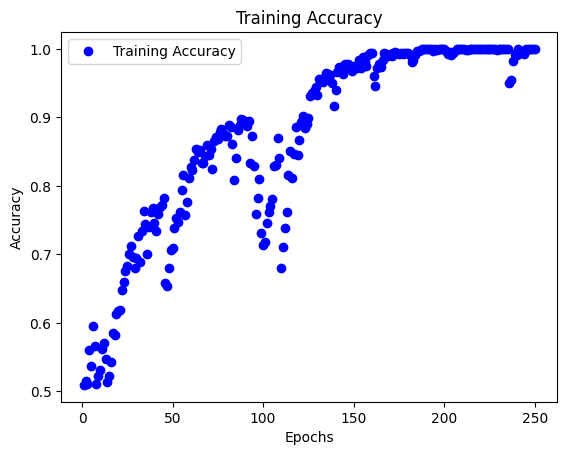

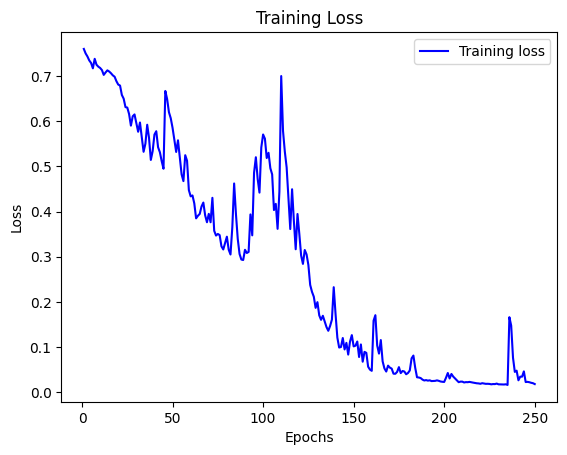

188


In [10]:
history_dict = history.history #Get the data stored from training

#Define plot of the accuracy
def plot_acc():
    plt.clf()
    acc = history_dict['accuracy']
    epochs = range(1, len(acc) + 1)
    solid_blue_line = 'b'

    plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

#Define plot of the loss
def plot_loss():
    loss = history_dict['loss']
    epochs = range(1, len(loss) + 1)
    solid_blue_line = 'b'

    plt.plot(epochs, loss, solid_blue_line, label = 'Training loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_acc()
plot_loss()
early_stopping_epoch = np.argmax(history.history["accuracy"])
print(early_stopping_epoch)

In [9]:
tf.keras.backend.clear_session()
new_model = tf.keras.models.load_model('saved_model/my_model')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               240400    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 32)                3232      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 2)                 3

In [10]:
new_model.fit(
    train_data,                     # full training set
    train_label,
    epochs=early_stopping_epoch, # the epoch where overfitting starts
    batch_size=150
)

Epoch 1/125
9/9 [==============================] - 3s 124ms/step - loss: 0.1780 - accuracy: 0.9477
Epoch 2/125
9/9 [==============================] - 1s 122ms/step - loss: 0.0572 - accuracy: 0.9836
Epoch 3/125
9/9 [==============================] - 1s 122ms/step - loss: 0.0332 - accuracy: 0.9945
Epoch 4/125
9/9 [==============================] - 1s 118ms/step - loss: 0.0229 - accuracy: 1.0000
Epoch 5/125
9/9 [==============================] - 1s 120ms/step - loss: 0.0200 - accuracy: 1.0000
Epoch 6/125
9/9 [==============================] - 1s 118ms/step - loss: 0.0194 - accuracy: 1.0000
Epoch 7/125
9/9 [==============================] - 1s 116ms/step - loss: 0.0174 - accuracy: 1.0000
Epoch 8/125
9/9 [==============================] - 1s 116ms/step - loss: 0.0166 - accuracy: 1.0000
Epoch 9/125
9/9 [==============================] - 1s 116ms/step - loss: 0.0156 - accuracy: 1.0000
Epoch 10/125
9/9 [==============================] - 1s 114ms/step - loss: 0.0155 - accuracy: 1.0000
Epoch 11/

In [17]:
new_model.save('saved_model/my_model')
final_model = tf.keras.models.load_model('saved_model/my_model')
score, acc = final_model.evaluate(test_data, test_label, verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


10/10 - 1s - loss: 1.2472 - accuracy: 0.7969 - 836ms/epoch - 84ms/step
Test score: 1.2472294569015503
Test accuracy: 0.796875
